In [1]:
! pip install -r requirements.txt


In [2]:
%matplotlib inline

import json
from torchsummary import summary
from environs import Env

from torchvision import datasets, transforms
from imageaug.transforms import Colorspace, RandomAdjustment, RandomRotatedCrop

from eva4.common import reset_seed, get_config, get_device, get_mean_std
from eva4.network import Net
from eva4.data_loader import get_train_loader, get_test_loader, get_train_data, get_test_data, print_test_data_stats, print_train_data_stats
from eva4.optimizer import get_optimizer
from eva4.scheduler import get_scheduler
from eva4.train import start_training

env = Env()
env.read_env("./mnist.experiment.env", recurse=False)

reset_seed()
model_config = get_config(env)
print("Experiment Config: ", json.dumps(model_config, sort_keys=False, indent=4))

Experiment Config:  {
    "cuda_available": false,
    "device": "cpu",
    "epochs": 10,
    "desired_accuracy": 99.4,
    "break_on_reaching_desired_accuracy": true,
    "consecutive_desired_accuracy": 3,
    "input_size": [
        1,
        28,
        28
    ],
    "input_channel": 1,
    "input_dimension": [
        28,
        28
    ],
    "dataset": "MNIST",
    "batch_size": 512,
    "shuffle": true,
    "num_workers": 1,
    "pin_memory": true,
    "dropout": 0.1,
    "bias_enabled": true,
    "optimizer": "SGD",
    "learning_rate": 0.1,
    "momentum": 0.9,
    "scheduler": "MultiStepLR",
    "step_size": 6,
    "milestones": [
        5,
        10
    ],
    "gamma": 0.1
}


In [3]:
from imageaug.transforms import Colorspace, RandomAdjustment, RandomRotatedCrop

crop_size = tuple(model_config.get("input_dimension"))
angle_std = 7 # in degrees

# simple transform
simple_transforms = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.ToPILImage(),
                                      transforms.Resize(crop_size),
                                      RandomRotatedCrop(crop_size, 0.0, angle_std, downscale=0.5),
                                      transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                      transforms.ToTensor(),
                                      ])

reset_seed()
train = get_train_data(simple_transforms, model_config)
test = get_test_data(simple_transforms, model_config)

train_data_mean, train_data_std = get_mean_std("Train", train)
test_data_mean, test_data_std = get_mean_std("Test", test)


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(0.3882)
 - mean: tensor(0.1297)
 - std: tensor(0.1232)
 - var: tensor(0.0152)
Train data_mean: 0.12974192202091217
Train data_std: 0.12321063876152039
[Test]
 - Numpy Shape: (10000, 28, 28)
 - Tensor Shape: torch.Size([10000, 28, 28])
 - min: tensor(0.)
 - max: tensor(0.2941)
 - mean: tensor(0.1037)
 - std: tensor(0.0984)
 - var: tensor(0.0097)
Test data_mean: 0.10365313291549683
Test data_std: 0.09835929423570633


In [4]:
from imageaug.transforms import Colorspace, RandomAdjustment, RandomRotatedCrop

train_transforms = transforms.Compose(
                                      simple_transforms.transforms + [
                                      transforms.Normalize((train_data_mean,), (train_data_std,))
                                      ])

test_transforms = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.ToPILImage(),
                                      transforms.Resize(crop_size),
                                      transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                      transforms.ToTensor(),
                                      transforms.Normalize((train_data_mean,), (train_data_std,))
                                      ])

In [5]:
reset_seed()
train_loader = get_train_loader(train_transforms, model_config)
test_loader = get_test_loader(test_transforms, model_config)

/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(0.3882)
 - mean: tensor(0.1297)
 - std: tensor(0.1232)
 - var: tensor(0.0152)
torch.Size([512, 1, 28, 28])
torch.Size([512])


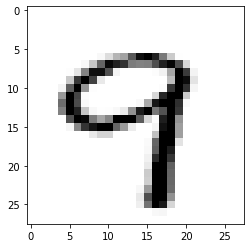

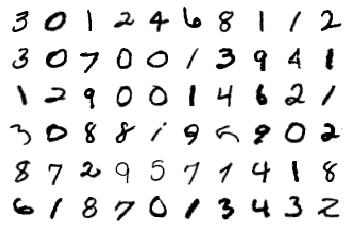

In [6]:
print_train_data_stats(train, train_loader)

[Test]
 - Numpy Shape: (10000, 28, 28)
 - Tensor Shape: torch.Size([10000, 28, 28])
 - min: tensor(0.)
 - max: tensor(0.2941)
 - mean: tensor(0.1037)
 - std: tensor(0.0984)
 - var: tensor(0.0097)


/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


torch.Size([512, 1, 28, 28])
torch.Size([512])


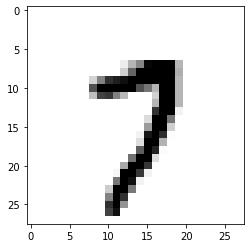

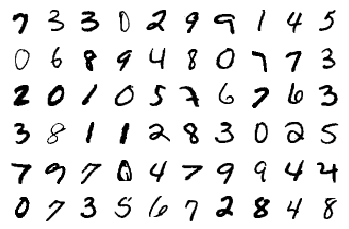

In [7]:
print_test_data_stats(test, test_loader)

In [8]:
reset_seed()
train_loader = get_train_loader(train_transforms, model_config)
test_loader = get_test_loader(test_transforms, model_config)

device = get_device(model_config)
model = Net(model_config).to(device)
optimizer = get_optimizer(model, model_config)
scheduler = get_scheduler(optimizer, model_config)

summary(model, input_size = model_config.get("input_size"))
start_training(model, device, train_loader, test_loader, optimizer, scheduler, model_config)

  0%|          | 0/118 [00:00<?, ?it/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
              ReLU-2            [-1, 8, 28, 28]               0
       BatchNorm2d-3            [-1, 8, 28, 28]              16
           Dropout-4            [-1, 8, 28, 28]               0
            Conv2d-5            [-1, 8, 28, 28]             584
              ReLU-6            [-1, 8, 28, 28]               0
       BatchNorm2d-7            [-1, 8, 28, 28]              16
           Dropout-8            [-1, 8, 28, 28]               0
            Conv2d-9           [-1, 16, 30, 30]             144
             ReLU-10           [-1, 16, 30, 30]               0
      BatchNorm2d-11           [-1, 16, 30, 30]              32
        MaxPool2d-12           [-1, 16, 15, 15]               0
           Conv2d-13           [-1, 16, 15, 15]           2,320
             ReLU-14           [-1, 16,

Loss=2.4559504985809326 Batch_id=0 Accuracy=12.89:   0%|          | 0/118 [00:02<?, ?it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 2.3035, Accuracy: 1032/10000 (10.32%)

EPOCH: 1


Loss=2.1813628673553467 Batch_id=0 Accuracy=21.09:   0%|          | 0/118 [00:02<?, ?it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 2.2988, Accuracy: 1444/10000 (14.44%)

EPOCH: 2


Loss=1.852062463760376 Batch_id=0 Accuracy=40.43:   0%|          | 0/118 [00:02<?, ?it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 2.2809, Accuracy: 1419/10000 (14.19%)

EPOCH: 3


Loss=1.5998045206069946 Batch_id=0 Accuracy=54.30:   0%|          | 0/118 [00:02<?, ?it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 2.2053, Accuracy: 2727/10000 (27.27%)

EPOCH: 4


Loss=1.299347996711731 Batch_id=0 Accuracy=67.58:   0%|          | 0/118 [00:02<?, ?it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 1.9976, Accuracy: 5813/10000 (58.13%)

EPOCH: 5


Loss=1.0619007349014282 Batch_id=0 Accuracy=71.48:   0%|          | 0/118 [00:02<?, ?it/s]


KeyboardInterrupt: 